In [0]:
import tensorflow as tf
import pathlib
import numpy as np
import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

### Mounting Google Drive and retrieving training set images

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_path = '/content/drive/My Drive/Colab Notebooks/mask-detector/'
data_dir_collected = pathlib.Path(os.path.join(base_path, 'data/training'))
data_dir_test = pathlib.Path(os.path.join(base_path, 'data/test'))
image_count_collected = len(list(data_dir_collected.glob('**/*.jpg')))
test_images_count = len(list(data_dir_test.glob('**/*.jpg')))
print('images collected', image_count_collected)
print('test images', test_images_count)

images collected 191
test images 495


In [4]:
CLASS_NAMES = np.array([item.name for item in data_dir_collected.glob('*')])
print(CLASS_NAMES)

['nomask' 'mask']


In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [6]:
IMG_WIDTH = 160
IMG_HEIGHT = 160
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir_collected),
                                                     shuffle=True,
                                                     target_size=IMG_SIZE,
                                                     classes = list(CLASS_NAMES))

Found 191 images belonging to 2 classes.


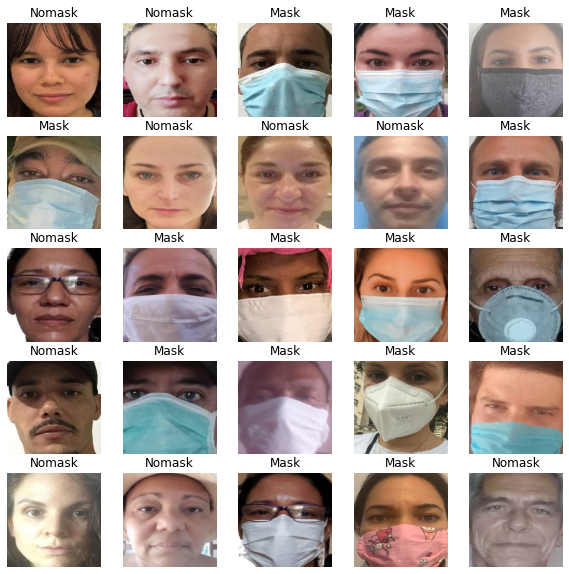

In [7]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [0]:
list_ds_collected = tf.data.Dataset.list_files(str(data_dir_collected/'*/*'))
list_ds_test = tf.data.Dataset.list_files(str(data_dir_test/'*/*'))

In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [26]:
train_ds = list_ds_collected.map(process_path)
validation_ds = list_ds_collected.map(process_path)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (160, 160, 3)
Label:  [ True False]


In [0]:
def get_data_generator():
    return ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

In [0]:
train_ds = train_ds.batch(image_count_collected)
validation_ds = validation_ds.batch(test_images_count)

In [0]:
datagen = get_data_generator()
image_batch, label_batch = next(iter(train_ds))
datagen.fit(image_batch)

In [0]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False


In [31]:
feature_batch = base_model(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(191, 2)


In [0]:
reps = 50
training_ds = train_ds.repeat(reps)
X_training, Y_training = next(iter(training_ds))

for X, Y in training_ds:
    X_training = tf.concat([X, X_training], axis=0)
    Y_training = tf.concat([Y, Y_training], axis=0)


In [33]:
X_test, Y_test = next(iter(validation_ds))
len(X_test)

9741

In [35]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.001
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

initial_epochs = 10
earlystopping = EarlyStopping(monitor='val_loss', patience=6)

batch_size = 100
print('fitting generator...')

print('training size',len(X_training))
history = model.fit(datagen.flow(X_training, Y_training, batch_size=batch_size),
                    steps_per_epoch=len(X_training) / batch_size,
                    epochs=initial_epochs,
                    validation_data=validation_ds,
                    use_multiprocessing=False,
                    )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
fitting generator...
training size 9741
Epoch 1/10
98/97 [==============================] - 47s 482ms/step - loss: 0.1136 - accuracy: 0.9585 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 2/10
98/97 [==============================] - 47s 477ms/step - loss: 0.0155 - accuracy: 0.9990 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 3/10
98/97 [============================

In [36]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

6/6 [==============================] - 0s 31ms/step - loss: 7.2485e-04 - accuracy: 1.0000
Testing Accuracy:  1.0000


In [0]:
model.save(os.path.join(base_path,'model.h5'))